In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from xgboost import XGBClassifier

import optuna

import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

In [2]:
RANDOM_STATE = 42
results = pd.DataFrame(columns = ['model', 'task', 'accuracy'])

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [3]:
data = pd.read_csv('winequality-red.csv', sep = ';')
data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%, предварительно выделив целевую переменную (колонка 'quality').

In [4]:

# Выделяем целевую переменную
X = data.drop(columns=['quality'])  # признаки
y = data['quality']  # целевая переменная

# Разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Вывод размеров полученных выборок
print("Размер обучающей выборки:", X_train.shape, y_train.shape)
print("Размер тестовой выборки:", X_test.shape, y_test.shape)


### Ваш код ###

Размер обучающей выборки: (1119, 11) (1119,)
Размер тестовой выборки: (480, 11) (480,)


2.Оцените качество на тестовой выборке по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [5]:

# Инициализация классификаторов
dt_classifier = DecisionTreeClassifier(random_state=42)
bagging_classifier = BaggingClassifier(n_estimators=100, random_state=42)
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучение классификаторов на обучающей выборке
dt_classifier.fit(X_train, y_train)
bagging_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)

# Предсказание на тестовой выборке
dt_pred = dt_classifier.predict(X_test)
bagging_pred = bagging_classifier.predict(X_test)
rf_pred = random_forest_classifier.predict(X_test)

# Оценка качества на тестовой выборке
acc_DT = accuracy_score(y_test, dt_pred)
acc_Bagging = accuracy_score(y_test, bagging_pred)
acc_RF = accuracy_score(y_test, rf_pred)


### Ваш код ###

# acc_DT = 0
# acc_Bagging = 0
# acc_RF = 0
results.loc[0] = ['DecisionTreeClassifier', 'task2', acc_DT]
results.loc[1] = ['BaggingClassifier ', 'task2', acc_Bagging]
results.loc[2] = ['RandomForestClassifier', 'task2', acc_RF]
results

model   task  accuracy
0  DecisionTreeClassifier  task2  0.572917
1      BaggingClassifier   task2  0.641667
2  RandomForestClassifier  task2  0.654167

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



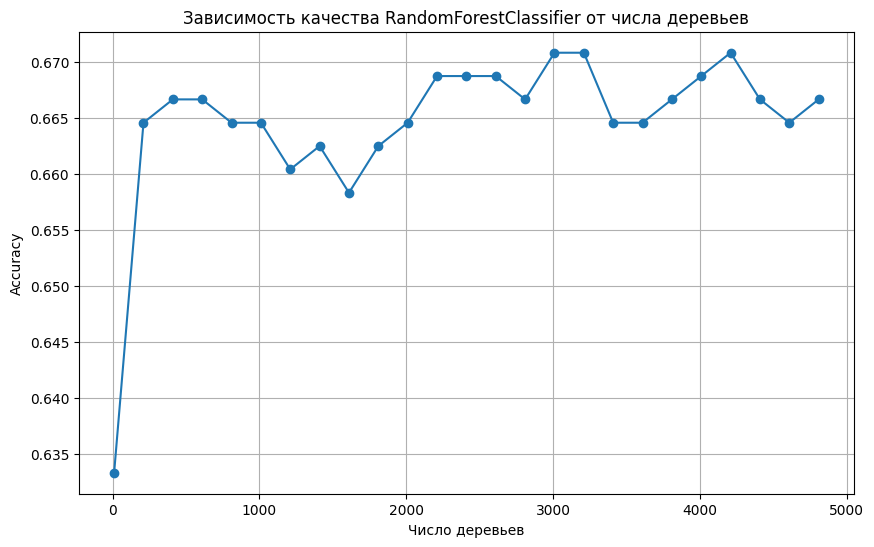

In [6]:


# Задаем значения числа деревьев
num_estimators = list(range(10, 5001, 200))

# Инициализация списка для сохранения значений accuracy
accuracy_scores = []

# Обучение и оценка качества для каждого значения числа деревьев
for n in num_estimators:
    rf_classifier = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_classifier.fit(X_train, y_train)
    rf_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, rf_pred)
    accuracy_scores.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(num_estimators, accuracy_scores, marker='o', linestyle='-')
plt.title('Зависимость качества RandomForestClassifier от числа деревьев')
plt.xlabel('Число деревьев')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Ваш код ###

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [7]:

y_train = np.where(y_train > 5, y_train - 6, y_train)

y_test = np.where(y_test > 5, y_test - 6, y_test)



In [8]:
# Инициализация классификаторов
gbc_classifier = GradientBoostingClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)

# Оценка качества с помощью кросс-валидации для GradientBoostingClassifier
acc_sklearn = np.mean(cross_val_score(gbc_classifier, X_train, y_train, cv=5, scoring='accuracy'))

# Оценка качества с помощью кросс-валидации для XGBClassifier
acc_xgboost = np.mean(cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy'))


### Ваш код ###

# acc_sklearn = 0
# acc_xgboost = 0
results.loc[3] = ['GradientBoostingClassifier', 'task4', acc_sklearn]
results.loc[4] = ['XGBClassifier', 'task4', acc_xgboost]
results

model   task  accuracy
0      DecisionTreeClassifier  task2  0.572917
1          BaggingClassifier   task2  0.641667
2      RandomForestClassifier  task2  0.654167
3  GradientBoostingClassifier  task4  0.645287
4               XGBClassifier  task4  0.649732

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [9]:


# Параметры для GradientBoostingClassifier
gbc_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Параметры для XGBClassifier
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# GridSearchCV для GradientBoostingClassifier
gbc_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_param_grid, cv=3, scoring='accuracy')
gbc_grid_search.fit(X_train, y_train)

# GridSearchCV для XGBClassifier
xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=3, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)


### Ваш код ###

best_params_sklearn = gbc_grid_search.best_params_
print('Параметры лучшей модели sklearn:\n', best_params_sklearn)
best_params_xgboost = xgb_grid_search.best_params_
print('Параметры лучшей модели xgboost:\n', best_params_xgboost)
acc_sklearn_cv = xgb_grid_search.best_score_
acc_xgboost_cv = gbc_grid_search.best_score_
results.loc[5] = ['GradientBoostingClassifier_CV', 'task5', acc_sklearn_cv]
results.loc[6] = ['XGBClassifier_CV', 'task5', acc_xgboost_cv]
results

Параметры лучшей модели sklearn:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Параметры лучшей модели xgboost:
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


model   task  accuracy
0         DecisionTreeClassifier  task2  0.572917
1             BaggingClassifier   task2  0.641667
2         RandomForestClassifier  task2  0.654167
3     GradientBoostingClassifier  task4  0.645287
4                  XGBClassifier  task4  0.649732
5  GradientBoostingClassifier_CV  task5  0.640751
6               XGBClassifier_CV  task5  0.646113

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [10]:


# Инициализация классификаторов
lgbm_classifier = LGBMClassifier(random_state=42)
catboost_classifier = CatBoostClassifier(random_state=42, silent=True)

# Оценка качества с помощью кросс-валидации для GradientBoostingClassifier
acc_lightgbm = cross_val_score(lgbm_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Оценка качества с помощью кросс-валидации для XGBClassifier
acc_catboost = cross_val_score(catboost_classifier, X_train, y_train, cv=5, scoring='accuracy')

print("Среднее значение accuracy для LightGBM:", np.mean(acc_lightgbm))
print("Среднее значение accuracy для CatBoost:", np.mean(acc_lightgbm))


### Ваш код ###

results.loc[7] = ['LGBMClassifier', 'task6', acc_lightgbm]
results.loc[8] = ['CatBoostClassifier', 'task6', acc_catboost]
results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score -0.938891
[LightGBM] [Info] Start training from score -2.096343
[LightGBM] [Info] Start training from score -4.494239
[LightGBM] [Info] Start training from score -4.850914
[LightGBM] [Info] Start training from score -3.429528
[LightGBM] [Info] Start training from score -0.833244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

model   task  \
0         DecisionTreeClassifier  task2   
1             BaggingClassifier   task2   
2         RandomForestClassifier  task2   
3     GradientBoostingClassifier  task4   
4                  XGBClassifier  task4   
5  GradientBoostingClassifier_CV  task5   
6               XGBClassifier_CV  task5   
7                 LGBMClassifier  task6   
8             CatBoostClassifier  task6   

                                            accuracy  
0                                           0.572917  
1                                           0.641667  
2                                           0.654167  
3                                           0.645287  
4                                           0.649732  
5                                           0.640751  
6                                           0.646113  
7  [0.6116071428571429, 0.6473214285714286, 0.589...  
8  [0.6071428571428571, 0.65625, 0.62946428571428...

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями.
Сравните значение метрики accuracy. Выведите лучшие параметры алгоритмов.

In [11]:


### Ваш код ###


# Параметры для LightGBM
lgbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Параметры для CatBoost
catboost_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# GridSearchCV для LightGBM
lgbm_grid_search = GridSearchCV(LGBMClassifier(random_state=42), lgbm_param_grid, cv=3, scoring='accuracy')
lgbm_grid_search.fit(X_train, y_train)

# GridSearchCV для CatBoost
catboost_grid_search = GridSearchCV(CatBoostClassifier(random_state=42, silent=True), catboost_param_grid, cv=3, scoring='accuracy')
catboost_grid_search.fit(X_train, y_train)


best_params_lightgbm = lgbm_grid_search.best_params_
print('Параметры лучшей модели lightgbm:\n', best_params_lightgbm)
best_params_catboost = catboost_grid_search.best_params_
print('Параметры лучшей модели catboost:\n', best_params_catboost)
acc_lightgbm_cv = lgbm_grid_search.best_score_
acc_catboost_cv = catboost_grid_search.best_score_
results.loc[9] = ['LGBMClassifier_CV', 'task7', acc_lightgbm_cv]
results.loc[10] = ['CatBoostClassifier_CV', 'task7', acc_catboost_cv]

results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 901
[LightGBM] [Info] Number of data points in the train set: 746, number of used features: 11
[LightGBM] [Info] Start training from score -0.937972
[LightGBM] [Info] Start training from score -2.092937
[LightGBM] [Info] Start training from score -4.535284
[LightGBM] [Info] Start training from score -4.822966
[LightGBM] [Info] Start training from score -3.436672
[LightGBM] [Info] Start training from score -0.833982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

model   task  \
0          DecisionTreeClassifier  task2   
1              BaggingClassifier   task2   
2          RandomForestClassifier  task2   
3      GradientBoostingClassifier  task4   
4                   XGBClassifier  task4   
5   GradientBoostingClassifier_CV  task5   
6                XGBClassifier_CV  task5   
7                  LGBMClassifier  task6   
8              CatBoostClassifier  task6   
9               LGBMClassifier_CV  task7   
10          CatBoostClassifier_CV  task7   

                                             accuracy  
0                                            0.572917  
1                                            0.641667  
2                                            0.654167  
3                                            0.645287  
4                                            0.649732  
5                                            0.640751  
6                                            0.646113  
7   [0.6116071428571429, 0.6473214285714286, 0.589...  
8   [0.6071428571428571, 0.65625, 0.62946428571428...  
9                                            0.624665  
10                                           0.644325

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [14]:


### Ваш код ###


def test(trial):
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.5]),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 7)
    }
    
    xgb_classifier = XGBClassifier(random_state=42, **params)
    score = cross_val_score(xgb_classifier, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(test, n_trials=100)

best_params_optuna = study.best_params
best_score_optuna = study.best_value

print("Лучшие параметры XGBoost, найденные с помощью Optuna:", best_params_optuna)
print("Лучшее значение accuracy, найденное с помощью Optuna:", best_score_optuna)

# Сравнение с поиском по сетке из scikit-learn
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

xgb_grid_search = GridSearchCV(XGBClassifier(random_state=42), xgb_param_grid, cv=3, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)

best_params_xgboost_optuna = xgb_grid_search.best_params_
acc_xgboost_optuna = xgb_grid_search.best_score_



print('Параметры лучшей модели xgboost:\n', best_params_xgboost_optuna)
results.loc[11] = ['XGBClassifier_optuna', 'task8', acc_xgboost_optuna]


[I 2024-02-15 16:57:16,123] A new study created in memory with name: no-name-da54d42c-1c86-4dd3-8003-c3dc8d1c3729


[I 2024-02-15 16:57:18,541] Trial 0 finished with value: 0.6371760500446827 and parameters: {'learning_rate': 0.1, 'n_estimators': 181, 'max_depth': 4}. Best is trial 0 with value: 0.6371760500446827.
[I 2024-02-15 16:57:20,402] Trial 1 finished with value: 0.5951742627345845 and parameters: {'learning_rate': 0.01, 'n_estimators': 124, 'max_depth': 6}. Best is trial 0 with value: 0.6371760500446827.
[I 2024-02-15 16:57:22,365] Trial 2 finished with value: 0.6416443252904379 and parameters: {'learning_rate': 0.1, 'n_estimators': 116, 'max_depth': 7}. Best is trial 2 with value: 0.6416443252904379.
[I 2024-02-15 16:57:23,991] Trial 3 finished with value: 0.6255585344057194 and parameters: {'learning_rate': 0.5, 'n_estimators': 144, 'max_depth': 5}. Best is trial 2 with value: 0.6416443252904379.
[I 2024-02-15 16:57:25,075] Trial 4 finished with value: 0.6309204647006256 and parameters: {'learning_rate': 0.5, 'n_estimators': 128, 'max_depth': 3}. Best is trial 2 with value: 0.641644325290

Лучшие параметры XGBoost, найденные с помощью Optuna: {'learning_rate': 0.1, 'n_estimators': 158, 'max_depth': 5}
Лучшее значение accuracy, найденное с помощью Optuna: 0.6425379803395889
Параметры лучшей модели xgboost:
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [15]:
results

model   task  \
0          DecisionTreeClassifier  task2   
1              BaggingClassifier   task2   
2          RandomForestClassifier  task2   
3      GradientBoostingClassifier  task4   
4                   XGBClassifier  task4   
5   GradientBoostingClassifier_CV  task5   
6                XGBClassifier_CV  task5   
7                  LGBMClassifier  task6   
8              CatBoostClassifier  task6   
9               LGBMClassifier_CV  task7   
10          CatBoostClassifier_CV  task7   
11           XGBClassifier_optuna  task8   

                                             accuracy  
0                                            0.572917  
1                                            0.641667  
2                                            0.654167  
3                                            0.645287  
4                                            0.649732  
5                                            0.640751  
6                                            0.646113  
7   [0.6116071428571429, 0.6473214285714286, 0.589...  
8   [0.6071428571428571, 0.65625, 0.62946428571428...  
9                                            0.624665  
10                                           0.644325  
11                                           0.640751

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [16]:

### Ваш код ###


base_models = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('gradient_boosting', GradientBoostingClassifier(random_state=42)),
    ('ada_boost', AdaBoostClassifier(random_state=42))
]

classifier = GradientBoostingClassifier(random_state=42)

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=classifier)

accuracy_scores = cross_val_score(stacking_classifier, X_train, y_train, cv=5, scoring='accuracy')


acc_stacking_default = accuracy_scores.mean()
results.loc[12] = ['Stacking', 'task10', acc_stacking_default]

results

model    task  \
0          DecisionTreeClassifier   task2   
1              BaggingClassifier    task2   
2          RandomForestClassifier   task2   
3      GradientBoostingClassifier   task4   
4                   XGBClassifier   task4   
5   GradientBoostingClassifier_CV   task5   
6                XGBClassifier_CV   task5   
7                  LGBMClassifier   task6   
8              CatBoostClassifier   task6   
9               LGBMClassifier_CV   task7   
10          CatBoostClassifier_CV   task7   
11           XGBClassifier_optuna   task8   
12                       Stacking  task10   

                                             accuracy  
0                                            0.572917  
1                                            0.641667  
2                                            0.654167  
3                                            0.645287  
4                                            0.649732  
5                                            0.640751  
6                                            0.646113  
7   [0.6116071428571429, 0.6473214285714286, 0.589...  
8   [0.6071428571428571, 0.65625, 0.62946428571428...  
9                                            0.624665  
10                                           0.644325  
11                                           0.640751  
12                                           0.655117

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [ ]:
results